In [65]:
using RxInferClientOpenAPI
using Plots, Statistics, LinearAlgebra

In [90]:
module Environment 
using Plots, LinearAlgebra

Base.@kwdef struct Drone
    gravity::Float64
    mass::Float64
    inertia::Vector{Float64}
    radius::Float64
    arm_length::Float64
    force_limit::Float64
end

get_gravity(drone::Drone) = drone.gravity
get_mass(drone::Drone) = drone.mass
get_inertia(drone::Drone) = Matrix(Diagonal(drone.inertia))
get_radius(drone::Drone) = drone.radius
get_arm_length(drone::Drone) = drone.arm_length
get_force_limit(drone::Drone) = drone.force_limit

function get_properties(drone::Drone)
    return (
        drone.gravity,
        drone.mass,
        Matrix(Diagonal(drone.inertia)),
        drone.radius,
        drone.arm_length,
        drone.force_limit
    )
end

function rotation_matrix(ψ, θ, ϕ)
    # Rotation matrices for each axis
    Rz = [
        cos(ψ) -sin(ψ) 0
        sin(ψ) cos(ψ) 0
        0 0 1
    ]

    Ry = [
        cos(θ) 0 sin(θ)
        0 1 0
        -sin(θ) 0 cos(θ)
    ]

    Rx = [
        1 0 0
        0 cos(ϕ) -sin(ϕ)
        0 sin(ϕ) cos(ϕ)
    ]

    # Combined rotation matrix (ZYX order)
    return Rz * Ry * Rx
end

function state_transition_3d(state, actions, drone::Drone, dt)
    # Extract properties
    g, m, I, r, L, limit = get_properties(drone)

    # Clamp motor forces
    F1, F2, F3, F4 = clamp.(actions, 0, limit)

    # Extract state
    x, y, z, vx, vy, vz, ϕ, θ, ψ, ωx, ωy, ωz = state

    # Current rotation matrix
    R = rotation_matrix(ψ, θ, ϕ)

    # Total thrust force in body frame
    F_total = sum([F1, F2, F3, F4])

    # Compute torques
    τx = L * (F2 - F4)  # roll torque
    τy = L * (F1 - F3)   # pitch torque
    τz = (F1 + F3 - F2 - F4) * r  # yaw torque

    # Forces in world frame
    F_world = R * [0, 0, F_total]

    # Accelerations
    ax = F_world[1] / m
    ay = F_world[2] / m
    az = F_world[3] / m - g

    # Angular accelerations
    α = I \ ([τx, τy, τz] - cross([ωx, ωy, ωz], I * [ωx, ωy, ωz]))

    # Update velocities
    vx_new = vx + ax * dt
    vy_new = vy + ay * dt
    vz_new = vz + az * dt

    # Update positions
    x_new = x + vx * dt + ax * dt^2 / 2
    y_new = y + vy * dt + ay * dt^2 / 2
    z_new = z + vz * dt + az * dt^2 / 2

    # Update angular velocities
    ωx_new = ωx + α[1] * dt
    ωy_new = ωy + α[2] * dt
    ωz_new = ωz + α[3] * dt

    # Update angles
    ϕ_new = ϕ + ωx * dt + α[1] * dt^2 / 2
    θ_new = θ + ωy * dt + α[2] * dt^2 / 2
    ψ_new = ψ + ωz * dt + α[3] * dt^2 / 2

    return [x_new, y_new, z_new, vx_new, vy_new, vz_new, ϕ_new, θ_new, ψ_new, ωx_new, ωy_new, ωz_new]
end

# Visualization function for 3D drone
function plot_drone_3d!(p, drone, state; color=:black)
    x, y, z, _, _, _, ϕ, θ, ψ, _, _, _ = state
    _, _, _, radius, arm_length, _ = get_properties(drone)
    
    # Create rotation matrix
    R = rotation_matrix(ψ, θ, ϕ)
    
    # Define arm endpoints in body frame (relative to center)
    arm_endpoints = [
        [arm_length, 0, 0],   # Right arm (X configuration)
        [0, arm_length, 0],   # Front arm
        [-arm_length, 0, 0],  # Left arm
        [0, -arm_length, 0]   # Back arm
    ]
    
    # Transform arm endpoints to world frame
    world_endpoints = []
    for endpoint in arm_endpoints
        # Convert endpoint to column vector for matrix multiplication
        endpoint_vec = reshape(endpoint, :, 1)
        # Apply rotation and translation
        world_point = R * endpoint_vec + [x, y, z]
        push!(world_endpoints, vec(world_point))
    end
    
    # Plot center
    scatter!(p, [x], [y], [z], color=color, label=false, markersize=5)
    
    # Plot arms and motors
    for endpoint in world_endpoints
        # Draw arm
        plot!(p, [x, endpoint[1]], [y, endpoint[2]], [z, endpoint[3]], 
              color=color, label=false, linewidth=2)
        # Draw motor
        scatter!(p, [endpoint[1]], [endpoint[2]], [endpoint[3]], 
                color=color, label=false, markersize=3)
    end
end
end

Main.Environment

In [91]:
client = RxInferClientOpenAPI.OpenAPI.Clients.Client("http://localhost:8000/v1")
RxInferClientOpenAPI.OpenAPI.Clients.set_header(client, "Authorization", "Bearer dev-token");

In [92]:
server_api = RxInferClientOpenAPI.ServerApi(client)
models_api = RxInferClientOpenAPI.ModelsApi(client);

In [93]:
response, info = RxInferClientOpenAPI.get_server_info(server_api)
response

{
  "rxinfer_version": "4.3.1",
  "server_version": "1.0.0-DEV",
  "server_edition": "CommunityEdition",
  "julia_version": "1.11.4",
  "api_version": "v1"
}


In [94]:
response, info = RxInferClientOpenAPI.get_models(models_api)
response

{
  "models": [
    {
      "name": "BetaBernoulli-v1",
      "description": "A simple Beta-Bernoulli model"
    },
    {
      "name": "Drone3D-v1",
      "description": "A 3D drone model"
    },
    {
      "name": "Drone2D-v1",
      "description": "A 2D drone model"
    }
  ]
}


In [95]:
drone = Environment.Drone(
    gravity = 9.81,
    mass = 1.0,
    inertia = [0.1, 0.1, 0.15],
    radius = 0.1,
    arm_length = 0.2,
    force_limit = 15
)

Main.Environment.Drone(9.81, 1.0, [0.1, 0.1, 0.15], 0.1, 0.2, 15.0)

In [138]:
create_model_req = RxInferClientOpenAPI.CreateModelRequest(
    model = "Drone3D-v1",
    description = "3D drone demonstration",
    arguments = Dict(
        "dt" => 0.05,
        "horizon" => 40,
        "gravity" => drone.gravity,
        "mass" => drone.mass,
        "inertia" => drone.inertia,
        "radius" => drone.radius,
        "arm_length" => drone.arm_length,
        "force_limit" => drone.force_limit
    )
)

response, _ = RxInferClientOpenAPI.create_model(models_api, create_model_req)
model_id = response.model_id

"4d6687a2-7abb-4587-9d06-0f25f975a559"

In [139]:
start = [
    0.0, 0.0, 0.0,  # position (x, y, z)
    0.0, 0.0, 0.0,  # velocity (vx, vy, vz)
    0.0, 0.0, 0.0,  # orientation (ϕ, θ, ψ)
    0.0, 0.0, 0.0   # angular velocity (ωx, ωy, ωz)
]
target = [ 0.4, 0.8, 0.2 ]

3-element Vector{Float64}:
 0.4
 0.8
 0.2

In [140]:
inference_req = RxInferClientOpenAPI.InferRequest(
    data = Dict(
        "current_state" => start,
        "target" => target,
    )
)
response, _ = RxInferClientOpenAPI.run_inference(models_api, model_id, inference_req);

In [141]:
states = [ start ]
for action in response.results["actions"]
    a = Float64.(action)
    current_state = last(states)
    next_state = Environment.state_transition_3d(current_state, a, drone, 0.05)
    push!(states, next_state)
end

Plots.AnimatedGif("/Users/bvdmitri/Projects/LazyDynamics/RxInferServer/examples/drone-plan.gif")
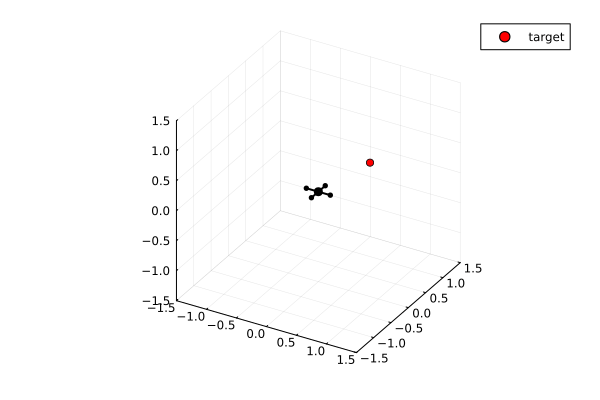

In [142]:
animation = @animate for k in 1:length(states)

    # plot target
    p = scatter([target[1]], [target[2]], [target[3]], label = "target"; color = :red)

    # plot drone
    Environment.plot_drone_3d!(p, drone, states[k])
    # Environment.plot_drone_3d!(p, drone, response.results["states"][k])

    xlims!(-1.5, 1.5)
    ylims!(-1.5, 1.5)
    zlims!(-1.5, 1.5)

end

gif(animation, "drone-plan.gif", show_msg = false)

In [157]:
function experiment_with_server()

    drone = Environment.Drone(
        gravity = 9.81,
        mass = 1.0,
        inertia = [0.1, 0.1, 0.15],
        radius = 0.1,
        arm_length = 0.2,
        force_limit = 15
    )

    dt = 0.05
    horizon = 20

    create_model_req = RxInferClientOpenAPI.CreateModelRequest(
        model = "Drone3D-v1",
        description = "3D drone demonstration",
        arguments = Dict(
            "dt" => dt,
            "horizon" => horizon,
            "gravity" => drone.gravity,
            "mass" => drone.mass,
            "inertia" => drone.inertia,
            "radius" => drone.radius,
            "arm_length" => drone.arm_length,
            "force_limit" => drone.force_limit
        )
    )
    
    response, _ = RxInferClientOpenAPI.create_model(models_api, create_model_req)
    model_id = response.model_id

    targets = [
        [ 0.4, 0.8, 0.0 ],
        [ -0.4, 0.8, -0.0 ],
        [ 0.6, 0.0, 0.0 ],
        [ 0.0, 0.6, -0.0 ],
        [ 0.7, -0.6, -0.0 ],
    ] 
    
    start = [
        0.0, 0.0, 0.0,  # position (x, y, z)
        0.0, 0.0, 0.0,  # velocity (vx, vy, vz)
        0.0, 0.0, 0.0,  # orientation (ϕ, θ, ψ)
        0.0, 0.0, 0.0   # angular velocity (ωx, ωy, ωz)
    ]

    current_state = copy(start)
    times = Float64[]
    
    animation = @animate for k in 1:250

        target = targets[mod(div(k, 50), length(targets)) + 1]

        start_time = time_ns()
        inference_req = RxInferClientOpenAPI.InferRequest(
            data = Dict(
                "current_state" => current_state,
                "target" => target,
            )
        )
        response, _ = RxInferClientOpenAPI.run_inference(models_api, model_id, inference_req);
        end_time = time_ns()

        push!(times, end_time - start_time)

        first_action = Float64.(response.results["actions"][1])

        next_state = Environment.state_transition_3d(current_state, first_action, drone, dt)
        current_state = copy(next_state)
    
        # plot target
        p = scatter([target[1]], [target[2]], [target[3]], label = "target"; color = :red)
    
        # plot drone
        Environment.plot_drone_3d!(p, drone, next_state)
    
        xlims!(-1.5, 1.5)
        ylims!(-1.5, 1.5)
        zlims!(-1.5, 1.5)
    
    end
    
    anim = gif(animation, "drone-plan.gif", show_msg = false)

    return anim, times
end

experiment_with_server (generic function with 1 method)

In [ ]:
anim, times = experiment_with_server()
anim

In [147]:
times_ms = map(tns -> tns / 10^6, times);

In [148]:
1 / mean(times_ms)

0.034001097058453014